In [2]:
import glob
import os.path as osp
import pickle
import random
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt

import datasets.dataset as dataset
from datasets.load_adni import load_adni2
#import models.models as models
from models.models import CNN, CNNAutoEncoder3D
from utils.data_class import BrainDataset
import torchio as tio
from tqdm import tqdm
import os
#from models.models import Vgg16, FujiNet1

/home/pocari/.pyenv/versions/onboarding2024/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# dataloader作成時にラベル情報を数値に変換するために使用するdict型変数
CLASS_MAP = {
    "CN": 0,
    "AD": 1,
}
# 再現性を保つために設定しておく値
SEED_VALUE = 0

In [4]:
# seed値を設定（random, Numpy, PyTorch）
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = (
        False  # この行をFalseにすると再現性はとれるが、速度が落ちる
    )
    torch.backends.cudnn.deterministic = True
    return

fix_seed(0)

In [5]:
# 脳MRIの画像を読み込み（今回は"CN", "AD"のみ）
dataset = load_adni2(classes=["CN", "AD"],size="half", unique=True, mni=False, strength=["3.0"])

# datasetの枚数を表示
len(dataset)

100%|██████████| 571/571 [00:37<00:00, 15.21it/s]


571

In [6]:
# datasetの1枚の情報を見てみる
dataset[0]

{'pid': '098_S_4003',
 'sex': 'F',
 'age': '72.4137',
 'weight': '56.7',
 'day': '2011-03-22',
 'uid': '225425',
 'preprocessing': 'MT1; GradWarp; N3m',
 'slice_thickness': '1.2',
 'plane': 'SAGITTAL',
 'x': '1.0156',
 'y': '1.0156',
 'manufacturer': 'GE MEDICAL SYSTEMS',
 'model': 'DISCOVERY MR750',
 'strength': '3.0',
 'class': 'CN',
 'mmse': '30.0',
 'moca': '24.0',
 'class_base': 'CN',
 'mmse_base': '30.0',
 'moca_base': '24.0',
 'path_full': '/data2/radiology_datas/clean3/ADNI2/full/rigid/225425.nii',
 'path_half': '/data2/radiology_datas/clean3/ADNI2/half/rigid/225425.nii',
 'path_full_mni': '/data2/radiology_datas/clean3/ADNI2/full/trsaa/225425.nii',
 'path_half_mni': '/data2/radiology_datas/clean3/ADNI2/half/trsaa/225425.nii',
 'voxel': memmap([[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ...

In [7]:
# datasetの」中から使用する情報をそれぞれ取ってくる
pids = []
voxels = np.zeros((len(dataset), 80, 112, 80))
labels = np.zeros(len(dataset))
for i in tqdm(range(len(dataset))):
    pids.append(dataset[i]["pid"])
    voxels[i] = dataset[i]["voxel"]
    # voxels[i] = normalize(voxels[i], np.min(voxels[i]), np.max(voxels[i]))
    labels[i] = CLASS_MAP[dataset[i]["class"]]
pids = np.array(pids)

100%|██████████| 571/571 [00:02<00:00, 194.99it/s]


In [8]:
# trainとtest用の画像を、同じ患者が分かれて入らないように分ける。

from sklearn.model_selection import StratifiedGroupKFold, train_test_split

# train_datadict, val_datadict = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=SEED_VALUE)

pids = []
for i in range(len(dataset)):
    pids.append(dataset[i]["pid"])
gss = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED_VALUE)
train_idx, val_idx = list(gss.split(voxels,labels, groups=pids))[0]
train_voxels = voxels[train_idx]
val_voxels = voxels[val_idx]
train_labels = labels[train_idx]
val_labels = labels[val_idx]

len(train_voxels)

456

In [9]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(0)

In [10]:
# train/val dataset を作成
train_set = BrainDataset(train_voxels, train_labels)
val_set = BrainDataset(val_voxels, val_labels)

print("size of the training dataset = ", len(train_set))
print("size of the validation dataset = ", len(val_set))
print("training image shape = {}, training label = {}".format(train_set(0)[0].shape, train_set(0)[1]))
print("test image shape = {}, test label = {}".format(val_set(0)[0].shape, val_set(0)[1]))

size of the training dataset =  456
size of the validation dataset =  115
training image shape = (1, 80, 112, 80), training label = 0.0
test image shape = (1, 80, 112, 80), test label = 0.0


In [11]:
# Function line up input images and output images
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error


def show_image(image):    
    %matplotlib inline

    fig = plt.figure(figsize=(18,5),dpi=600)
    X, Y = 1, 6
    
    for i in range(6):
        imgplot = i + 1
        ax1 = fig.add_subplot(X, Y, imgplot)
        print(f"type={image.dtype}")
        img = np.flip(image.reshape(80, 112, 80).transpose(1,2,0)[50+i],0)
        plt.axis("off")
        plt.imshow(img,cmap="gray")
        plt.tick_params(labelsize=8)
        
    plt.show()

type=float32
type=float32
type=float32
type=float32
type=float32
type=float32


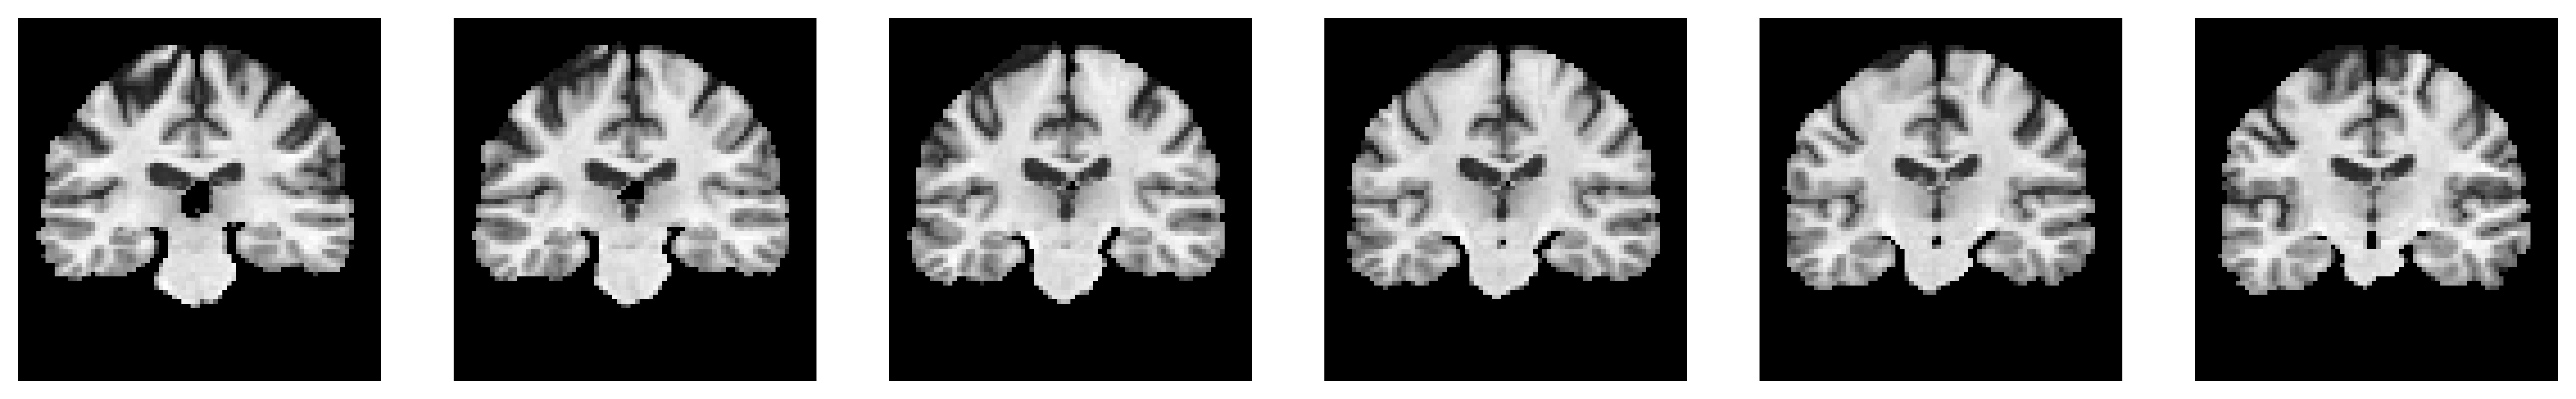

In [12]:
idx = 20
image, label = train_set(idx)

show_image(image)

In [15]:
train_dataloader = DataLoader(train_set, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=16, shuffle=False)

# 保存ディレクトリ
os.makedirs('reconstructed_image_CNN_100epoch', exist_ok=True)

# デバイス
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 潜在次元リスト
latent_dims = [2, 8, 16, 32, 64, 128, 256]
reconstruction_errors = []

# ===================================
# 学習ループ＆再構成・誤差計算
# ===================================
for latent_dim in latent_dims:
    print(f"\n=== Latent Dimension: {latent_dim} ===")

    model = CNNAutoEncoder3D(latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    # 学習
    model.train()
    for epoch in range(100):  # epoch数
        total_loss = 0
        for x, _ in train_dataloader:
            x = x.to(device)
            optimizer.zero_grad()
            x_hat = model(x)
            loss = criterion(x_hat, x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Train Loss: {total_loss/len(train_dataloader):.4f}")

    # 再構成誤差（検証データ）
    model.eval()
    total_loss = 0
    count = 0
    with torch.no_grad():
        for x, _ in val_dataloader:
            x = x.to(device)
            x_hat = model(x)
            loss = criterion(x_hat, x)
            total_loss += loss.item() * x.size(0)
            count += x.size(0)
    avg_loss = total_loss / count
    reconstruction_errors.append(avg_loss)
    print(f"Validation Reconstruction Error (MSE): {avg_loss:.6f}")

    # 再構成画像保存（中央スライス）
    test_imgs = next(iter(val_dataloader))[0][:8].to(device)
    with torch.no_grad():
        reconstructed = model(test_imgs)

    fig, axes = plt.subplots(2, 8, figsize=(12,3))
    for i in range(8):
        mid_slice = test_imgs[i].shape[2] // 2  # Z軸中央
        axes[0,i].imshow(test_imgs[i,0,mid_slice,:,:].cpu().numpy(), cmap='gray')
        axes[0,i].axis('off')
        axes[1,i].imshow(reconstructed[i,0,mid_slice,:,:].cpu().numpy(), cmap='gray')
        axes[1,i].axis('off')
    plt.tight_layout()
    plt.savefig(f'reconstructed_image_CNN_100epoch/reconstructed_grid_latent_{latent_dim}.png')
    plt.close()

# 再構成誤差グラフ
plt.figure(figsize=(8,5))
plt.plot(latent_dims, reconstruction_errors, marker='o', linestyle='-')
plt.title("Latent Dimension vs Reconstruction Error (3D CNN AE)") # 潜在次元数と再構成誤差の関係
plt.xlabel("Latent Dimension") # 潜在空間
plt.ylabel("Reconstruction Error (MSE)") # 再構成誤差(MSE)
plt.grid(True)
plt.savefig("reconstructed_image_CNN_100epoch/areconstruction_error_plot.png")
plt.close()

print("\n✅ 完了：3D CNN AutoEncoderの再構成画像と誤差グラフを保存しました。")


=== Latent Dimension: 2 ===
Epoch 1, Train Loss: 0.1407
Epoch 2, Train Loss: 0.0343
Epoch 3, Train Loss: 0.0192
Epoch 4, Train Loss: 0.0179
Epoch 5, Train Loss: 0.0175
Epoch 6, Train Loss: 0.0170
Epoch 7, Train Loss: 0.0167
Epoch 8, Train Loss: 0.0185
Epoch 9, Train Loss: 0.0170
Epoch 10, Train Loss: 0.0165
Epoch 11, Train Loss: 0.0161
Epoch 12, Train Loss: 0.0158
Epoch 13, Train Loss: 0.0155
Epoch 14, Train Loss: 0.0153
Epoch 15, Train Loss: 0.0151
Epoch 16, Train Loss: 0.0185
Epoch 17, Train Loss: 0.0175
Epoch 18, Train Loss: 0.0168
Epoch 19, Train Loss: 0.0165
Epoch 20, Train Loss: 0.0163
Epoch 21, Train Loss: 0.0161
Epoch 22, Train Loss: 0.0159
Epoch 23, Train Loss: 0.0161
Epoch 24, Train Loss: 0.0158
Epoch 25, Train Loss: 0.0158
Epoch 26, Train Loss: 0.0155
Epoch 27, Train Loss: 0.0168
Epoch 28, Train Loss: 0.0174
Epoch 29, Train Loss: 0.0168
Epoch 30, Train Loss: 0.0167
Epoch 31, Train Loss: 0.0167
Epoch 32, Train Loss: 0.0166
Epoch 33, Train Loss: 0.0165
Epoch 34, Train Loss: 0